# UTILS FILE

In [2]:
!pip install ale-py
!pip install gymnasium

from ale_py import ALEInterface
ale = ALEInterface()
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

import gymnasium as gym
import gymnasium.utils.seeding as seeding
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import tempfile
import torch

from IPython.display import Image
from collections import deque
from gymnasium.wrappers import RecordVideo
from moviepy.editor import VideoFileClip
from typing import NamedTuple

tempfile.tempdir = './'

# The device to use for PyTorch. Just defined here for convenience.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# The default random seed used in the lectures.
DEFAULT_RANDOM_SEED=10

def init_random(env: gym.Env=None, seed=DEFAULT_RANDOM_SEED):
    """Initializes all the random generators used by frameworks to a default value.

    If `env` is specified, it sets also the env random generator and return the env itself. That is
    just a convenient setup for the notebooks, even if arguably not the best structured code setup.
    """
    try:
      random.seed(seed)
      np.random.seed(seed)
      torch.manual_seed(seed)
      # torch.use_deterministic_algorithms(True)
      if env is not None:
          env.np_random, _ = seeding.np_random(seed)
          env.reset(seed=seed)
    except Exception as e:
        print(e)
    return env

def epsilon_gen(eps_start=1.0, eps_decay=0.99999, eps_min=0.05):
    """Generator function for Ɛ and its decay (e.g., exploration via Ɛ-greedy policy)."""
    eps = eps_start
    while True:
        yield eps
        eps = max(eps * eps_decay, eps_min)

def soft_update_model_params(src: torch.nn.Module, dest: torch.nn.Module, tau=1e-3):
    """Soft updates model parameters (θ_dest = τ * θ_src + (1 - τ) * θ_src)."""
    for dest_param, src_param in zip(dest.parameters(), src.parameters()):
        dest_param.data.copy_(tau * src_param.data + (1.0 - tau) * dest_param.data)

class Experience(NamedTuple):
    """A single step / experience of an agent stored in the replay buffer."""
    state:      np.array
    action:     float
    reward:     float
    next_state: np.array
    done:       bool

class ReplayBuffer:
    """Simple replay buffer for off-policy deep reinforcement learning algorithms.

    IMPORTANT: This ReplayBuffer is specifically tuned for the DDPG / TD3 / SAC algorithms in these
    lectures. In particular, the action space is a single float scalar. If you want to adapt those
    algorithms to different environments, you will need to update this code accordingly as well.
    """
    def __init__(self, buffer_size=int(1e5)):
        """Initializes the buffer with an internal deque of size `buffer_size`."""
        self.memory = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        """Stores a single step / experience of an agent."""
        e = Experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size: int = 128):
        """Randomly selects `batch_size` items from the buffer, stacks them, and returns them."""
        all_indices = np.arange(len(self.memory))
        selection = np.random.choice(all_indices, size=batch_size)
        return self.unpack(selection)

    def unpack(self, selection):
        """Given the `selection` of experiences, returns them as a tuple of stacked values.

        This is convenient for the usage in the various learning algorithms so that they don't have
        to do it themselves.
        """
        experiences = [e for i in selection if (e := self.memory[i]) is not None]
        states, actions, rewards, next_states, dones = zip(*experiences)
        states      = torch.from_numpy(np.stack(states)).float().to(DEVICE)
        actions     = torch.from_numpy(np.vstack(actions)).float().to(DEVICE) # NOTE: float scalar!
        rewards     = torch.from_numpy(np.vstack(rewards)).float().to(DEVICE)
        next_states = torch.from_numpy(np.stack(next_states)).float().to(DEVICE)
        dones       = torch.from_numpy(np.vstack(dones, dtype=np.uint8)).float().to(DEVICE)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

def show_gym_video_recording(name_prefix: str = 'rl-video', folder: str = None):
    """Shows the recorded video of episode 0 of a gym environment."""
    if folder == None:
        folder = tempfile.tempdir
    video_file = os.path.join(folder, f'{name_prefix}-episode-0.mp4')
    video_clip = VideoFileClip(video_file)
    gif_file = os.path.join('./', 'rl-video.gif')
    video_clip.write_gif(gif_file, fps=15)
    video_clip.close()
    return Image(open(gif_file, 'rb').read())

def plot_scores(scores, rolling_window=25):
    """Plots training scores and their running average."""
    avgs = pd.Series(scores).rolling(rolling_window).mean()
    x = np.arange(len(scores))
    plt.figure('Episode scores')
    plt.plot(x, scores, label='Scores')
    plt.plot(x, avgs, 'r', label='Running average')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    return plt.show()

def gym_simulation(env_name: str, agent=None, max_t=1_000, env_kwargs={}):
    """Runs a simulation of an agent in an initialized gym environment and plays the video."""
    sim_env = gym.make(env_name, render_mode="rgb_array_list", **env_kwargs)
    sim_env = init_random(sim_env)
    sim_env = RecordVideo(sim_env, './', lambda i: i == 0)
    state, _ = sim_env.reset()
    for _ in range(max_t):
        action = agent.act(state) if agent is not None else sim_env.action_space.sample()
        next_state, _, terminated, truncated, _ = sim_env.step(action)
        if terminated or truncated:
            break
        state = next_state
    sim_env.close()
    return show_gym_video_recording()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 11.7 MB/s eta 0:00:00


  if event.key is 'enter':



# Actor-Critic Methods

In _value-based_ methods, we use a value function to determine the optimal policy. The exploration
and exploitation tradeoff is left to manual tuning. In _policy-based_ methods, we learn the policy
directly, but the Monte Carlo methods have high-variance and tend to be slower (mitigating that by
collecting more samples causes the algorithm to be less sample-efficient).

Actor-critic methods combine the two approaches:

 * We learn the _actor_ policy, to control how the agent behave.
 * We measure how good the chosen actions are via a _critic_, which learns the value function.

Remember the _baseline_ in policy gradient? The _critic_ helps computing it!

In [3]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import gymnasium as gym

# from util.gymnastics import DEVICE, ReplayBuffer, gym_simulation
# from util.gymnastics import init_random, plot_scores, soft_update_model_params

## Environment

  logger.warn(



MoviePy - Building file ./rl-video.gif with imageio.


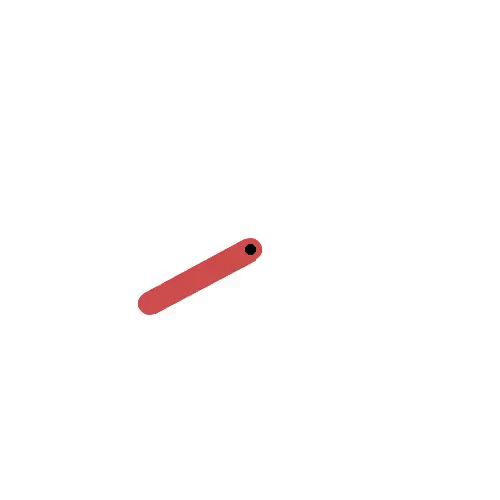

In [4]:
gym_simulation("Pendulum-v1")

In [17]:
# For convenience, harcoding actions' interval [-2.0, 2.0]
ACTION_SCALE = 2.0

## General (1-Step) Algorithm

The simplified version of an [actor-critic](https://arxiv.org/abs/1602.01783) algorithm goes as
follows:

 1. In state $S_t$, the _actor_ outputs the action $A_t$ using the policy $\pi_{\theta}(S_t)$ and
    obtaining $R_{t+1}$ and $S_{t+1}$
 2. The _critic_ outputs the value of state and next state: $V_t = \^{v_w}(S_t),
    V_{t+1} = \^{v_w}(S_{t+1})$
 3. We compute the _advantage_: $A_t = Q(s_t, a_t) - V(s_t) = [R_{t+1} + \gamma V_{t+1}] - V_t$
 3. The _actor_ updates the policy parameters $\theta$ using the _advantage_:
    $\space \space \Delta \theta = \alpha \nabla_{\theta} [ log \pi_{\theta}(S_t) ] A_t$
 4. The _critic_ updates the value function parameters $w$ minimizing $A_t$
 5. Repeat

The _advantage actor critic (A2C)_ algorithm works basically this way. For a robust implementation,
check [Stable Baselines3 A2C](https://stable-baselines3.readthedocs.io/en/master/modules/a2c.html).

## Neural Network Models

In [4]:
class CopyModule(nn.Module):

    def __init__(self, *args, **kwargs):

        super().__init__() # make sure nn.Module init is called

        self._args = args
        self._kwargs = kwargs

    @classmethod
    def create_copy(cls, source_network, eval = True):

        sd = source_network.state_dict() # creates a state dict
        with torch.no_grad():
            target = cls(*source_network._args, **source_network._kwargs) # initialize the network
            target.load_state_dict(sd)

        for (p, cp) in zip(source_network.parameters(), target.parameters()): # instant test case
            assert torch.allclose(p.data, cp.data)

        if eval:
            target.eval()

        return target

    def copy_network(self, source_network):

        # copies source from target
        sd = source_network.state_dict() # creates a state dict
        with torch.no_grad():
            self.load_state_dict(sd)

In [5]:
class ActorNetwork(CopyModule):

    """Actor (Policy) Model."""
    def __init__(self, state_size, action_size, fc1_units=400, fc2_units=300):

        super(ActorNetwork, self).__init__(state_size, action_size, fc1_units, fc2_units)

        # TODO: Create three linear layers, first two initialized via Kaiming normal, the last one
        #       with uniform distribution in [-3e-3, 3e-3]. the input of the policy network is a
        #       state, while the output a (continuous) action.

        self.enc = nn.Sequential(
            nn.Linear(state_size, fc1_units),
            nn.ReLU(),
            nn.Linear(fc1_units, fc2_units),
            nn.ReLU()
        )

        self.fin = nn.Sequential(
            nn.Linear(fc2_units, action_size),
            nn.Tanh()
        )

        self._init_params()

    def _init_params(self):

        for name, param in self.enc.named_parameters():
            if 'bias' in name: continue
            nn.init.kaiming_uniform_(param.data, mode='fan_in')

        nn.init.uniform_(self.fin[0].weight.data, a = -3e-3, b = 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        # TODO: Use ReLU, ReLU, TanH :)
        # Make it a batch if not a batch
        # if len(state.shape) < 2: state = state[None, :]

        inter = self.enc(state)
        return self.fin(inter)

In [6]:
class CriticNetwork(CopyModule):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, fcs1_units=400, fc2_units=300):

        super(CriticNetwork, self).__init__(state_size, action_size, fcs1_units, fc2_units)

        self.l = nn.Sequential(
            nn.Linear(state_size + action_size, fcs1_units),
            nn.ReLU(),
            nn.Linear(fcs1_units, fc2_units),
            nn.ReLU(),
            nn.Linear(fc2_units, 1)
        )

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        # state - (bs, state_space)
        # action - (bs, action_space)
        # Make it a batch if not a batch
        if len(state.shape) < 2: state = state[None, :]
        if len(action.shape) < 2: action = action[None, :]

        x = torch.cat((state, action), dim = 1) # bs, state_space + action_space
        return self.l(x)


## Q-Learning Based Actor-Critic Algorithms

We are going to implement modern actor-critic algorithms such as DDPG, TD3, SAC. They are closely
related to Q-Learning, and in-between DQN and policy-gradient methods. All these algorithms are
analyzed in detail in [OpenAI SpinningUp](https://spinningup.openai.com/en/latest) and I strongly
recommend to read that amazing resource!

That is because these algorithms learn approximators for the optimal action-value function
$Q^*(s, a)$ and optimal (deterministic, excluding SAC) policy $a^*(s) = \argmax_{a} Q^*(s, a)$
exploting the fact that the action-value function is differentiable.

Finding the max of the action-value function would be an optimization problem in and of itself, but
instead we learn a deterministic policy $\mu(s)$ such that: $Q(s, \mu(s)) \approx \max_a Q^(s,a)$.
All of these algorithms are off-policy and use a replay buffer (like DQN).


## Training Loop

In [7]:
def train_actor_critic(env, agent, n_episodes=1_000, max_t=300):
    """General training loop for actor-critic algorithms in this lecture."""
    # Records all episode scores.
    scores = []
    for i_episode in range(1, n_episodes+1):

        state, _ = env.reset()
        score = 0

        # Run training for max_timesteps.
        for _ in range(max_t):

            action = agent.act(state, add_noise=True) # what is it with add_noise and why should we do it?
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.step(state, action, reward, next_state, done)

            # Update state, score, and check termination.
            state = next_state
            score += reward

            if done:
                break

        scores.append(score)
        avg_score = np.mean(scores[-100:])
        print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}',
              end="\n" if i_episode % 50 == 0 else "")
        if avg_score >= -370:
            print(f'\rEpisode {i_episode} solved environment!\tAverage Score: {avg_score:.2f}')
            break

    return scores

## DDPG

The _Deep Deterministic Policy Gradient_ algorithm can be thought the DQN algorithm for continuous
action spaces, and it uses the same techniques: replay-buffer + target-networks (for both actor and
critic).

We already leant how the _actor_ learns a deterministic policy $\mu(s)$ maximizing the critic value.
The _critic_ learns the action-value function $Q(s, a)$ minimizing a _mean-squared Bellman error_
(MSBE - the squared _advantage_ if you will) like DQN.

Because the policy is deterministic, the _exploration / exploitation_ tradeoff can be tuned adding
noise to the action. In the [original paper](https://proceedings.mlr.press/v32/silver14.pdf), the
authors recommended to use
[Ornstein-Uhlenbeck noise](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process), but
it turns out that a zero-mean Gaussian noise works just as well (hence, we'll use that here).

In [8]:
class AgentDDPG:
    def __init__(self, state_size, action_size, start_mem_size=128,
                  gamma=0.99, lr_actor=1e-4, lr_critic=1e-3, exploration_noise_scale=0.1):

        self.state_size = state_size
        self.action_size = action_size
        self.start_mem_size = start_mem_size
        self.gamma = gamma
        self.exploration_noise_scale = exploration_noise_scale

        self.actor        = ActorNetwork(3, 1)
        self.actor_target = ActorNetwork.create_copy(self.actor)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = lr_actor)

        self.critic        = CriticNetwork(3, 1)
        self.critic_target = CriticNetwork.create_copy(self.critic)

        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = lr_critic)

        self.memory = ReplayBuffer()
        self.c = 0

    @torch.no_grad
    def act(self, state: np.array, add_noise=False):
        """Returns actions for given state as per current policy."""
        state = torch.Tensor(state).to(torch.float32)
        action = self.actor_target(state) # bs, 1
        if add_noise:
            action += torch.randn_like(action) * self.exploration_noise_scale

        action.clip_(-ACTION_SCALE, ACTION_SCALE)

        return action.data.numpy()

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # state, action, reward, next_state, done
        action = action.squeeze().item()
        reward = reward.squeeze().item()
        if isinstance(state, torch.Tensor):
            state = state.numpy()

        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > self.start_mem_size:
            exps = self.memory.sample(self.start_mem_size)
            self.learn(exps)


    def learn(self, experiences):

        states, actions, rewards, next_states, dones = experiences
        self.critic.train()
        self.actor.train()
        # CRITIC UPDATE.
        Q_values = self.critic(states, actions)

        with torch.no_grad():
            actions_next = self.actor_target(next_states)
            Q_targets_next = self.critic_target(next_states, actions_next)
            Q_targets = rewards + self.gamma * Q_targets_next * (1 - dones)

        critic_loss = F.huber_loss(Q_values, Q_targets)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ACTOR UPDATE.
        actions_pred = self.actor(states)
        actor_loss = -1.*(self.critic_target(states, actions_pred).mean())

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.c += 1
        if self.c == 2:
            self.c = 0
            soft_update_model_params(self.actor, self.actor_target)
            soft_update_model_params(self.critic, self.critic_target)

Episode 50	Average Score: -1207.71
Episode 100	Average Score: -1284.84
Episode 150	Average Score: -1178.41
Episode 200	Average Score: -831.54
Episode 250	Average Score: -469.99
Episode 270 solved environment!	Average Score: -366.52


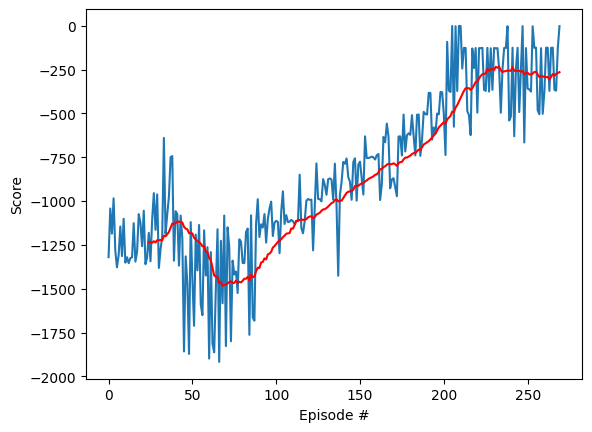

In [11]:
with init_random(gym.make('Pendulum-v1')) as env:
    agent_ddpg = AgentDDPG(env.observation_space.shape[0], env.action_space.shape[0])
    scores_ddpg = train_actor_critic(env, agent_ddpg)
plot_scores(scores_ddpg)

  logger.warn(



MoviePy - Building file ./rl-video.gif with imageio.


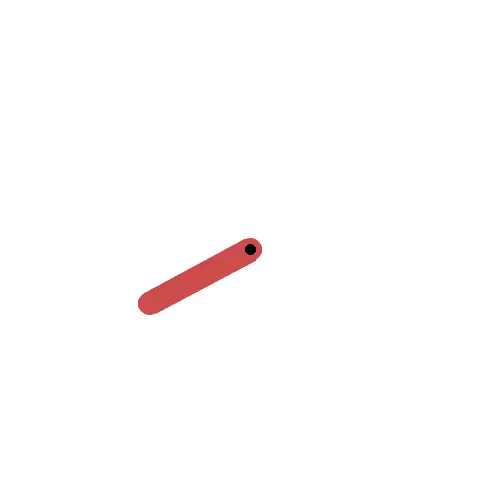

In [12]:
gym_simulation("Pendulum-v1", agent_ddpg)

## TD3

The _Twin Delayed DDPG_ (TD3) algorithm expands on DDPG with a couple of additional tricks:

 * It learns _two_ Q functions, and uses the smaller Q value to for the target. That is to address
   overestimation of Q values in DDPG. The "_twin_" part of the name comes from this.
 * Updates the policy (and target) networks less frequently than the Q function (hence, "_delayed_")
   and that is to keep the target and learning more stable.
 * Finally, it adds noise to the target action to "smooth out" the action value and make it harder
   for the policy to exploit errors in the Q function.

In [28]:
class AgentTD3:
    def __init__(self, state_size, action_size, start_mem_size=128,
                 gamma=0.99, lr_actor=1e-4, lr_critic=1e-3, exploration_noise_scale=0.1,
                 policy_noise = 0.2, noise_clamp=0.5,
                 policy_freq=2):

        self.state_size = state_size
        self.action_size = action_size
        self.start_mem_size = start_mem_size
        self.gamma = gamma
        self.exploration_noise_scale = exploration_noise_scale
        self.policy_noise = policy_noise
        self.noise_clamp = noise_clamp
        self.policy_freq = policy_freq
        self.t_step = 0

        # Actor network (w/ target network)
        self.actor        = ActorNetwork(3, 1)
        self.actor_target = ActorNetwork.create_copy(self.actor)

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = lr_actor)

        # TD3 trick n.1: Twin critic networks (w/ target network)
        self.twin_critic_1        = CriticNetwork(3, 1)
        self.twin_critic_2        = CriticNetwork(3, 1)

        self.twin_critic_1_t      = CriticNetwork.create_copy(self.twin_critic_1)
        self.twin_critic_2_t      = CriticNetwork.create_copy(self.twin_critic_2)

        params = (i for i in list(self.twin_critic_1.parameters()) + list(self.twin_critic_2.parameters()))
        self.critic_optimizer     = torch.optim.Adam(params, lr = lr_critic)

        self.memory = ReplayBuffer()

    @torch.no_grad
    def act(self, state, add_noise=False):

        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).to(torch.float32)
        action = self.actor(state)
        # In the original paper, the noise is generated via an Ornstein-Uhlenbeck process. It turns
        # out, a normal gaussian noise works just as well. Hence, that's what we use.
        if add_noise:
            action += torch.randn_like(action) * self.exploration_noise_scale

        return action.data.numpy()

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""

        self.t_step += 1
        if isinstance(state, torch.Tensor):
            state = state.data.numpy()
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > self.start_mem_size:
            exp = self.memory.sample(self.start_mem_size)
            self.learn(exp)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # UPDATE TWIN CRITICS.
        with torch.no_grad():
            actions_next = self.actor_target(next_states)

            noise = torch.randn_like(actions_next) * self.exploration_noise_scale
            noise.clamp_(-ACTION_SCALE, ACTION_SCALE)

            actions_next += noise
            actions_next.clamp_(-ACTION_SCALE, ACTION_SCALE)

            Q_targets_next_1 = self.twin_critic_1_t(next_states, actions_next)
            Q_targets_next_2 = self.twin_critic_2_t(next_states, actions_next)

            Q_targets_next = torch.min(Q_targets_next_1, Q_targets_next_2)
            Q_targets = rewards + self.gamma*(Q_targets_next*(1 - dones))

        #Compute the Q_values of both twin critics.
        Q_values_1 = self.twin_critic_1(states, actions)
        Q_values_2 = self.twin_critic_2(states, actions)
        critic_loss = F.huber_loss(Q_values_1, Q_targets) + F.huber_loss(Q_values_2, Q_targets)

        # Minimize the critic loss.
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        if self.t_step % self.policy_freq == 0:

            actions_pred = self.actor(states)

            min_qvalue = torch.min(self.twin_critic_1(states, actions_pred),
                                   self.twin_critic_2(states, actions_pred))

            actor_loss = -1*(min_qvalue.mean())

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            soft_update_model_params(self.actor, self.actor_target)
            soft_update_model_params(self.twin_critic_1, self.twin_critic_1_t)
            soft_update_model_params(self.twin_critic_2, self.twin_critic_2_t)


Episode 50	Average Score: -1542.22
Episode 100	Average Score: -1371.55
Episode 150	Average Score: -964.13
Episode 200	Average Score: -511.51
Episode 220 solved environment!	Average Score: -369.19


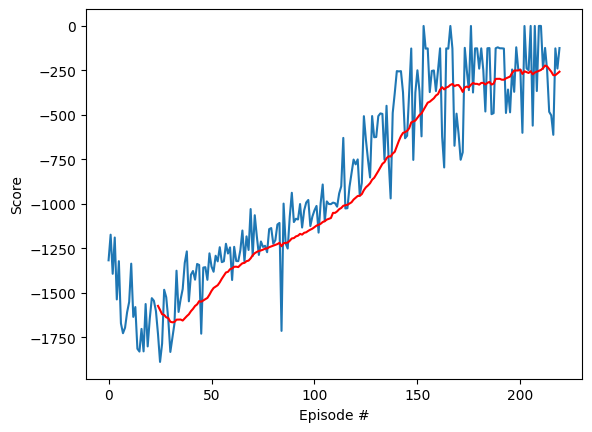

In [29]:
with init_random(gym.make('Pendulum-v1')) as env:
    agent_td3 = AgentTD3(env.observation_space.shape[0], env.action_space.shape[0])
    scores_td3 = train_actor_critic(env, agent_td3)
plot_scores(scores_td3)

MoviePy - Building file ./rl-video.gif with imageio.


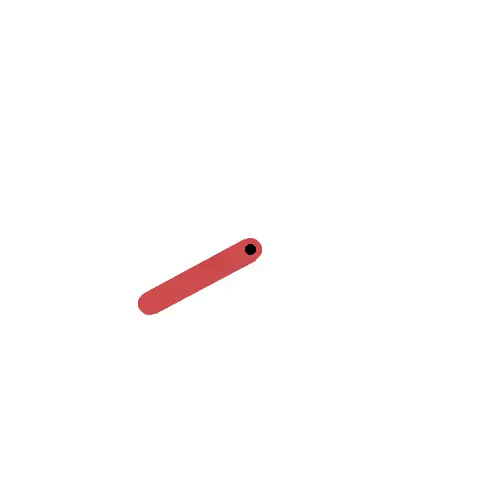

In [30]:
gym_simulation("Pendulum-v1", agent_td3)

## SAC (Optional)

The _Soft Actor Critic_ (SAC) algorithm is an off-policy algorithm similar to DDPG and TD3, that
learns a stochastic policy instead. It adopts many of the techniques used in TD3, but it stems from
the _Maximum Entropy Formulation_ of reinforcement learning.

For an in-depth understanding of both max-ent and SAC, I suggest watching
[Lecture 1](https://www.youtube.com/watch?v=2GwBez0D20A&list=PLwRJQ4m4UJjNymuBM9RdmB3Z9N5-0IlY0&index=2)
of Peter Abbeel Deep RL course, and reading the OpenAI SpinningUp SAC summary.

In short and as a highlight, in this formulation of RL the optimization objective is to maximize the
expected return plus the _entropy_ of the policy $H[ \pi (a | s_t)]$, term that intuitively balance
exploration and exploitation:

$$
\max_{\pi} \mathbb{E}\Bigl[ \sum_{t=0}^{T} r_t + \beta H[ \pi (a | s_t)] \Bigr]
$$

The _entropy_ in fact "measures" how uncertain is a policy (i.e., a deterministic policy has a very
low entropy, while a random one has high entropy).

While the _critic_ network learns the action-value as usual, the _actor_ network learns the mean
and standard deviation of a Gaussian representing the stochastic policy, using `tanh` to "squash"
the values in an acceptable range, and having the `logstd` depending on the network parameters as
well.

In [34]:
class ActorNetworkSAC(nn.Module):
    """The actor network for SAC. It is provided given its technicalities."""

    def __init__(self, state_size, action_size, action_scale=ACTION_SCALE, action_bias=0.0):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, action_size)
        self.fc_logstd = nn.Linear(256, action_size)
        self.action_scale = action_scale
        self.action_bias = action_bias

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        mean    = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        return mean, self.adjust_log_std(log_std)

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        sample = normal.rsample() # Reparameterization trick: (mean + std * N(0,1))
        output = torch.tanh(sample)
        log_prob = normal.log_prob(sample)
        # Enforcing action bounds (and non-zero log)
        action = output * self.action_scale + self.action_bias
        log_prob -= torch.log(self.action_scale * (1 - output.pow(2)) + 1e-6)
        return action, log_prob

    def adjust_log_std(self, log_std):
        log_std_min, log_std_max = (-5, 2) # From SpinUp / Denis Yarats
        return log_std_min + 0.5 * (log_std_max - log_std_min) * (log_std + 1)

In [59]:
class AgentSAC:
    def __init__(self, state_size, action_size, start_mem_size=128,
                 gamma=0.99, lr_actor=1e-4, lr_critic=1e-3, policy_freq=2):
        self.state_size = state_size
        self.action_size = action_size
        self.start_mem_size = start_mem_size
        self.gamma = gamma
        self.policy_freq = policy_freq
        self.t_step = 0

        # Build the actor network with the ActorNetworkSAC (no target!)
        self.actor = ActorNetworkSAC(3, 1)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        # Build twin critics like in TD3.
        self.twin_critic_1        = CriticNetwork(3, 1)
        self.twin_critic_2        = CriticNetwork(3, 1)

        self.twin_critic_1_t      = CriticNetwork.create_copy(self.twin_critic_1)
        self.twin_critic_2_t      = CriticNetwork.create_copy(self.twin_critic_2)

        params = (i for i in list(self.twin_critic_1.parameters()) + list(self.twin_critic_2.parameters()))
        self.critic_optimizer     = torch.optim.Adam(params, lr = lr_critic)

        # REPLAY BUFFER
        self.memory = ReplayBuffer()

    @torch.no_grad
    def act(self, state, add_noise=False): # SAC doesn't really have noise, but for consistency...
        """Returns actions for given state as per current policy."""
        # TODO: Convert the numpy state to a tensor.
        state = torch.from_numpy(state).to(torch.float32)

        # TODO: Get the action calling `get_action` from the actor.
        action, _ = self.actor.get_action(state)
        # TODO: Return the numpy action.
        return action.data.numpy()

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.t_step += 1

        # TODO: Save experience / reward in the memory.
        if isinstance(state, torch.Tensor):
            state = state.data.numpy()
        self.memory.add(state, action, reward, next_state, done)

        if len(self.memory) > self.start_mem_size:
            exp = self.memory.sample(self.start_mem_size)
            self.learn(exp)

    def learn(self, experiences, alpha=0.2):
        states, actions, rewards, next_states, dones = experiences

        # UPDATE TWIN CRITICS
        with torch.no_grad():

            actions_next, log_pi_next_st = self.actor.get_action(next_states)
            entropy_term = alpha * log_pi_next_st

            critic_1_qs_t = self.twin_critic_1_t(next_states, actions_next)
            critic_2_qs_t = self.twin_critic_2_t(next_states, actions_next)

            Q_targets = rewards + self.gamma*(torch.min(critic_1_qs_t, critic_2_qs_t) - entropy_term)*(1-dones)

        critic_1_qs = self.twin_critic_1(states, actions)
        critic_2_qs = self.twin_critic_2(states, actions)

        loss = F.huber_loss(critic_1_qs, Q_targets) + F.huber_loss(critic_2_qs, Q_targets)

        # Minimize the critic loss.
        self.critic_optimizer.zero_grad()
        loss.backward()
        self.critic_optimizer.step()

        # UPDATE ACTOR.
        if self.t_step % self.policy_freq == 0:

            action, log_pi = self.actor.get_action(states)
            entropy_term = alpha * log_pi

            Q_values_1 = self.twin_critic_1(states, action)
            Q_values_2 = self.twin_critic_2(states, action)

            Q_values = torch.min(Q_values_1, Q_values_2)

            policy_grads = (Q_values - entropy_term)
            actor_loss = -1.*policy_grads.mean()

            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            soft_update_model_params(self.twin_critic_1, self.twin_critic_1_t)
            soft_update_model_params(self.twin_critic_2, self.twin_critic_2_t)

Episode 50	Average Score: -1512.16
Episode 100	Average Score: -1271.67
Episode 150	Average Score: -684.62
Episode 182 solved environment!	Average Score: -368.28


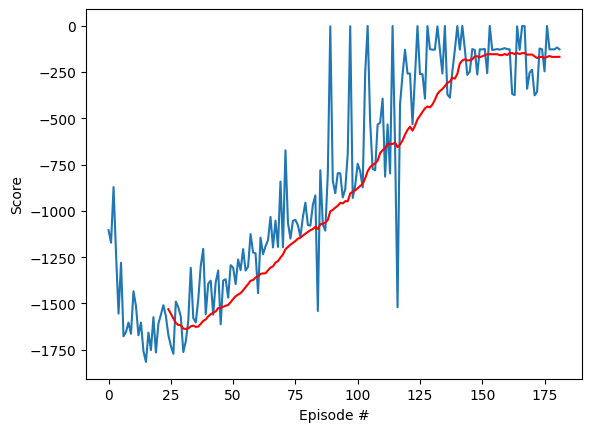

In [60]:
with init_random(gym.make('Pendulum-v1')) as env:
    agent_sac = AgentSAC(env.observation_space.shape[0], env.action_space.shape[0])
    scores_sac = train_actor_critic(env, agent_sac)
plot_scores(scores_sac)

  logger.warn(



MoviePy - Building file ./rl-video.gif with imageio.


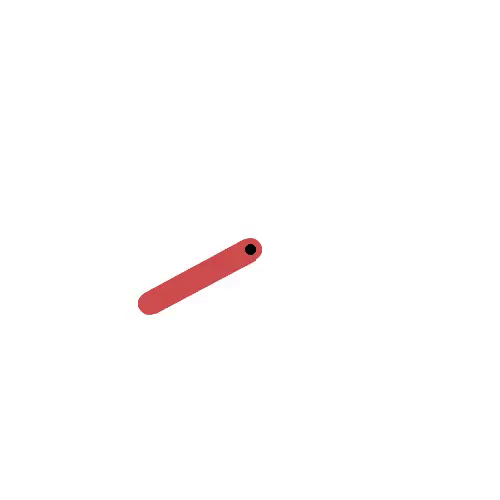

In [61]:
gym_simulation("Pendulum-v1", agent_sac)